# IMPORTS

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from copy import deepcopy

import utils
%matplotlib inline
# Any results you write to the current directory are saved as output.

# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import keras.backend as K

In [5]:
import utils
import plot_utils

In [6]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [7]:
# import tools for data building
import build_data_final as bd

# GET DATA, AGGREGATE AND CREATE SINGLE DATASET

In [9]:
df = bd.build_data(num_rows=None)

loaded application_train (356255, 121)
one hot encoded main data (356255, 250)
bureau_and_balance (305811, 118)
previous_applications (338857, 235)
pos_cash (337252, 17)
installments_payments (339587, 26)
credit_card_balance (103558, 136)
added bureau_and_balance (356255, 368)
added previous_applications (356255, 603)
added pos_cash (356255, 620)
added installments_payments (356255, 646)
added credit_card_balance (356255, 782)
added new features (356255, 900)
cleaned columns with single values (356255, 896)


In [10]:
# save dataset to disk
df.to_csv('../data/data_all_final.csv',header=True)

# BUILD MODEL, EVALUATE AND STORE SUBMISSION FILE

In [10]:
# data_all_final = pd.read_csv('../data/data_all_final.csv', sep=',', nrows=None)
data_all_final = df.reset_index()
data_all_final.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,PAYMENT_RATE^3,PAYMENT_RATE^2 AMT_ANNUITY,PAYMENT_RATE^2 DAYS_EMPLOYED,PAYMENT_RATE AMT_ANNUITY^2,PAYMENT_RATE AMT_ANNUITY DAYS_EMPLOYED,PAYMENT_RATE DAYS_EMPLOYED^2,AMT_ANNUITY^3,AMT_ANNUITY^2 DAYS_EMPLOYED,AMT_ANNUITY DAYS_EMPLOYED^2,DAYS_EMPLOYED^3
0,100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,0.000224,91.156539,-2.350832,3.706402e+07,-9.558422e+05,24650.169232,1.507014e+13,-3.886431e+11,1.002270e+10,-2.584749e+08
1,100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,0.000021,27.190385,-0.904861,3.517083e+07,-1.170440e+06,38950.727798,4.549356e+13,-1.513967e+12,5.038286e+10,-1.676677e+09
2,100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,0.000125,16.875000,-0.562500,2.278125e+06,-7.593750e+04,2531.250000,3.075469e+11,-1.025156e+10,3.417188e+08,-1.139062e+07
3,100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0.000856,267.589977,-27.393123,8.367070e+07,-8.565350e+06,876832.870936,2.616236e+13,-2.678235e+12,2.741703e+11,-2.806675e+10
4,100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,39.723134,-5.519146,2.037797e+07,-2.831322e+06,393384.810491,1.045390e+13,-1.452468e+12,2.018064e+11,-2.803905e+10


In [11]:
# Display/plot feature importance
def display_importances(feature_importance_df_, filename):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(filename+'.png')

In [12]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

def kfold_lightgbm(df, num_folds, filename, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            objective='binary',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(filename+'.csv', index= False)
    display_importances(feature_importance_df, filename)
    return feature_importance_df

Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.777326	valid_1's auc: 0.76051
[200]	training's auc: 0.799427	valid_1's auc: 0.775179
[300]	training's auc: 0.813521	valid_1's auc: 0.781743
[400]	training's auc: 0.824619	valid_1's auc: 0.785158
[500]	training's auc: 0.83372	valid_1's auc: 0.787318
[600]	training's auc: 0.841376	valid_1's auc: 0.788589
[700]	training's auc: 0.848119	valid_1's auc: 0.789435
[800]	training's auc: 0.854583	valid_1's auc: 0.790043
[900]	training's auc: 0.86067	valid_1's auc: 0.790609
[1000]	training's auc: 0.866276	valid_1's auc: 0.791062
[1100]	training's auc: 0.871375	valid_1's auc: 0.791308
[1200]	training's auc: 0.876209	valid_1's auc: 0.791334
[1300]	training's auc: 0.881164	valid_1's auc: 0.791287
Early stopping, best iteration is:
[1117]	training's auc: 0.872157	valid_1's auc: 0.79136
Fold  1 AUC : 0.791360
Training until validation scores don

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


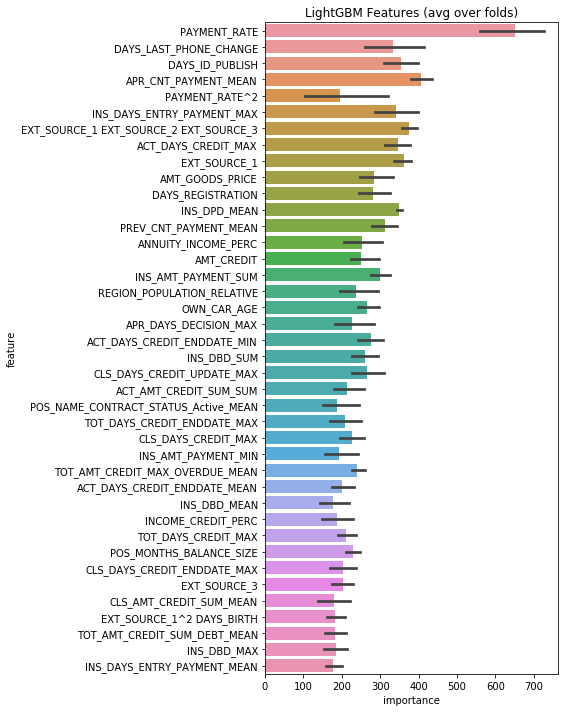

In [17]:
# set the filename
filename = 'submission_full_5_quad_LGBM_kfold_strat_obj_binary'
# run LGBM
feat_importance = kfold_lightgbm(data_all_final, num_folds= 5, filename = filename, stratified = True, debug = False)

In [ ]:
# SUBMISSION: public score = 0.792

## SAME MODEL WITH NORMALIZED DATA 

In [40]:
def clean_numerical_data(data_in, verbose=False):
    """
     cleans up numerical data
    """
    
    #do NOT manipulate target variable
    y = data_in['TARGET']
    data_in.drop(columns = 'TARGET', inplace=True)
    
    # Imputation: replace nan values with mean
    imputer = Imputer()
    data_out = imputer.fit_transform(data_in)
    
    # Normalization
    scaler = StandardScaler()
    data_out = scaler.fit_transform(data_out)
    #data_out = scaler.fit_transform(data_in)
    
    
    data_out = pd.DataFrame(data=data_out,    # values
     index=data_in.index,    # 1st column as index
     columns=data_in.keys())

    data_out = data_out.join(y)
    
    return data_out

In [37]:
data_all_final_norm = clean_numerical_data(df)
data_all_final_norm = data_all_final_norm.reset_index()
data_all_final_norm.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,PAYMENT_RATE^2 AMT_ANNUITY,PAYMENT_RATE^2 DAYS_EMPLOYED,PAYMENT_RATE AMT_ANNUITY^2,PAYMENT_RATE AMT_ANNUITY DAYS_EMPLOYED,PAYMENT_RATE DAYS_EMPLOYED^2,AMT_ANNUITY^3,AMT_ANNUITY^2 DAYS_EMPLOYED,AMT_ANNUITY DAYS_EMPLOYED^2,DAYS_EMPLOYED^3,TARGET
0,100002,-0.184975,-0.454489,-0.483765,0.144890,-6.472996e-02,-7.825789e-02,-2.908006e-01,-0.415563,-1.683781e-01,...,-0.052646,0.477540,-0.167610,0.503062,-0.392682,-0.179340,0.375635,-0.368665,0.260478,1.0
1,100003,0.561561,1.770432,1.643740,0.446895,-6.472996e-02,-7.825789e-02,-2.908006e-01,-0.415563,-1.683781e-01,...,-0.585271,0.605035,-0.186240,0.459008,-0.381055,0.012550,0.157501,-0.313277,0.254731,0.0
2,100004,-1.403441,-1.135828,-1.074055,-0.459119,-6.472996e-02,-7.825789e-02,-2.908006e-01,-0.415563,-1.683781e-01,...,-0.671164,0.635222,-0.509919,0.683694,-0.410665,-0.272452,0.448982,-0.381950,0.261480,0.0
3,100006,0.153471,-0.690088,-0.631337,-0.157114,8.938119e-18,3.505805e-17,-3.483568e-17,0.000000,-3.895203e-17,...,1.416457,-1.730506,0.291021,-1.059059,0.300174,-0.109378,-0.068182,-0.006162,0.147788,0.0
4,100007,-0.377413,-0.187564,-0.041047,-0.217515,-6.472996e-02,-7.825789e-02,-2.908006e-01,-0.415563,-1.683781e-01,...,-0.480915,0.198181,-0.331809,0.118054,-0.092887,-0.208456,0.169422,-0.105471,0.147900,0.0


Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.775596	valid_1's auc: 0.75933
[200]	training's auc: 0.797638	valid_1's auc: 0.773493
[300]	training's auc: 0.811398	valid_1's auc: 0.779946
[400]	training's auc: 0.822404	valid_1's auc: 0.784064
[500]	training's auc: 0.83144	valid_1's auc: 0.786324
[600]	training's auc: 0.83899	valid_1's auc: 0.787697
[700]	training's auc: 0.845603	valid_1's auc: 0.788746
[800]	training's auc: 0.851693	valid_1's auc: 0.789415
[900]	training's auc: 0.857511	valid_1's auc: 0.789992
[1000]	training's auc: 0.862926	valid_1's auc: 0.790233
[1100]	training's auc: 0.868058	valid_1's auc: 0.790583
[1200]	training's auc: 0.872648	valid_1's auc: 0.790776
[1300]	training's auc: 0.877333	valid_1's auc: 0.790962
[1400]	training's auc: 0.881623	valid_1's auc: 0.791059
[1500]	training's auc: 0.885899	valid_1's auc: 0.791088
[1600]	training's auc: 0.890097	valid

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


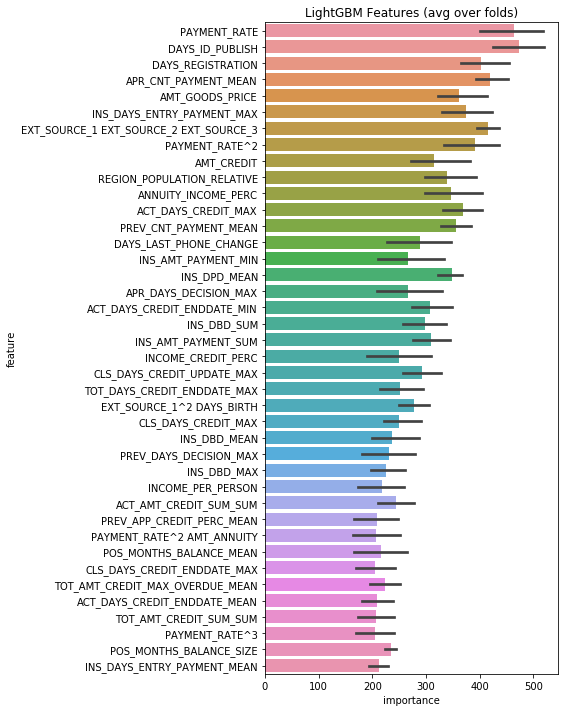

In [45]:
# set the filename
filename = 'submission_full_6_quad_norm_LGBM_kfold_strat_obj_binary'
# run LGBM
feat_importance = kfold_lightgbm(data_all_final_norm, num_folds= 5, filename = filename, stratified = True, debug = False)

## GRID SEARCH

In [42]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

def kfold_lightgbm_grid(df, num_folds, filename, n_estimators=10000, learning_rate=0.02, num_leaves=34, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            objective='binary',
            nthread=4,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(filename+'.csv', index= False)
    display_importances(feature_importance_df, filename)
    return feature_importance_df

submission_full_grid_n_estimators_9000_num_leaves_32
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.775845	valid_1's auc: 0.759895
[200]	training's auc: 0.797705	valid_1's auc: 0.774655
[300]	training's auc: 0.811173	valid_1's auc: 0.781195
[400]	training's auc: 0.822013	valid_1's auc: 0.785204
[500]	training's auc: 0.83093	valid_1's auc: 0.787121
[600]	training's auc: 0.838608	valid_1's auc: 0.788497
[700]	training's auc: 0.845312	valid_1's auc: 0.789476
[800]	training's auc: 0.851842	valid_1's auc: 0.790214
[900]	training's auc: 0.857435	valid_1's auc: 0.790653
[1000]	training's auc: 0.862897	valid_1's auc: 0.791079
[1100]	training's auc: 0.867979	valid_1's auc: 0.791287
[1200]	training's auc: 0.872876	valid_1's auc: 0.791406
[1300]	training's auc: 0.877504	valid_1's auc: 0.791334
[1400]	training's auc: 0.882213	valid_1's auc: 0.791506
[1500]	training's auc: 0.886369	valid_

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_9000_num_leaves_34
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.777326	valid_1's auc: 0.76051
[200]	training's auc: 0.799427	valid_1's auc: 0.775179
[300]	training's auc: 0.813521	valid_1's auc: 0.781743
[400]	training's auc: 0.824619	valid_1's auc: 0.785158
[500]	training's auc: 0.83372	valid_1's auc: 0.787318
[600]	training's auc: 0.841376	valid_1's auc: 0.788589
[700]	training's auc: 0.848119	valid_1's auc: 0.789435
[800]	training's auc: 0.854583	valid_1's auc: 0.790043
[900]	training's auc: 0.86067	valid_1's auc: 0.790609
[1000]	training's auc: 0.866276	valid_1's auc: 0.791062
[1100]	training's auc: 0.871375	valid_1's auc: 0.791308
[1200]	training's auc: 0.876209	valid_1's auc: 0.791334
[1300]	training's auc: 0.881164	valid_1's auc: 0.791287
Early stopping, best iteration is:
[1117]	training's auc: 0.872157	valid_1's auc: 0.79136
Fold  

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_9000_num_leaves_36
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.778775	valid_1's auc: 0.761042
[200]	training's auc: 0.80105	valid_1's auc: 0.77546
[300]	training's auc: 0.815302	valid_1's auc: 0.781897
[400]	training's auc: 0.82647	valid_1's auc: 0.785672
[500]	training's auc: 0.835982	valid_1's auc: 0.787896
[600]	training's auc: 0.843848	valid_1's auc: 0.789283
[700]	training's auc: 0.850721	valid_1's auc: 0.790131
[800]	training's auc: 0.857106	valid_1's auc: 0.790753
[900]	training's auc: 0.86315	valid_1's auc: 0.791209
[1000]	training's auc: 0.868793	valid_1's auc: 0.791674
[1100]	training's auc: 0.873999	valid_1's auc: 0.791859
[1200]	training's auc: 0.879269	valid_1's auc: 0.791929
[1300]	training's auc: 0.884017	valid_1's auc: 0.792062
[1400]	training's auc: 0.88884	valid_1's auc: 0.792185
[1500]	training's auc: 0.893135	valid_1's 

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_10000_num_leaves_32
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.775845	valid_1's auc: 0.759895
[200]	training's auc: 0.797705	valid_1's auc: 0.774655
[300]	training's auc: 0.811173	valid_1's auc: 0.781195
[400]	training's auc: 0.822013	valid_1's auc: 0.785204
[500]	training's auc: 0.83093	valid_1's auc: 0.787121
[600]	training's auc: 0.838608	valid_1's auc: 0.788497
[700]	training's auc: 0.845312	valid_1's auc: 0.789476
[800]	training's auc: 0.851842	valid_1's auc: 0.790214
[900]	training's auc: 0.857435	valid_1's auc: 0.790653
[1000]	training's auc: 0.862897	valid_1's auc: 0.791079
[1100]	training's auc: 0.867979	valid_1's auc: 0.791287
[1200]	training's auc: 0.872876	valid_1's auc: 0.791406
[1300]	training's auc: 0.877504	valid_1's auc: 0.791334
[1400]	training's auc: 0.882213	valid_1's auc: 0.791506
[1500]	training's auc: 0.886369	valid

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_10000_num_leaves_34
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.777326	valid_1's auc: 0.76051
[200]	training's auc: 0.799427	valid_1's auc: 0.775179
[300]	training's auc: 0.813521	valid_1's auc: 0.781743
[400]	training's auc: 0.824619	valid_1's auc: 0.785158
[500]	training's auc: 0.83372	valid_1's auc: 0.787318
[600]	training's auc: 0.841376	valid_1's auc: 0.788589
[700]	training's auc: 0.848119	valid_1's auc: 0.789435
[800]	training's auc: 0.854583	valid_1's auc: 0.790043
[900]	training's auc: 0.86067	valid_1's auc: 0.790609
[1000]	training's auc: 0.866276	valid_1's auc: 0.791062
[1100]	training's auc: 0.871375	valid_1's auc: 0.791308
[1200]	training's auc: 0.876209	valid_1's auc: 0.791334
[1300]	training's auc: 0.881164	valid_1's auc: 0.791287
Early stopping, best iteration is:
[1117]	training's auc: 0.872157	valid_1's auc: 0.79136
Fold 

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_10000_num_leaves_36
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.778775	valid_1's auc: 0.761042
[200]	training's auc: 0.80105	valid_1's auc: 0.77546
[300]	training's auc: 0.815302	valid_1's auc: 0.781897
[400]	training's auc: 0.82647	valid_1's auc: 0.785672
[500]	training's auc: 0.835982	valid_1's auc: 0.787896
[600]	training's auc: 0.843848	valid_1's auc: 0.789283
[700]	training's auc: 0.850721	valid_1's auc: 0.790131
[800]	training's auc: 0.857106	valid_1's auc: 0.790753
[900]	training's auc: 0.86315	valid_1's auc: 0.791209
[1000]	training's auc: 0.868793	valid_1's auc: 0.791674
[1100]	training's auc: 0.873999	valid_1's auc: 0.791859
[1200]	training's auc: 0.879269	valid_1's auc: 0.791929
[1300]	training's auc: 0.884017	valid_1's auc: 0.792062
[1400]	training's auc: 0.88884	valid_1's auc: 0.792185
[1500]	training's auc: 0.893135	valid_1's

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_11000_num_leaves_32
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.775845	valid_1's auc: 0.759895
[200]	training's auc: 0.797705	valid_1's auc: 0.774655
[300]	training's auc: 0.811173	valid_1's auc: 0.781195
[400]	training's auc: 0.822013	valid_1's auc: 0.785204
[500]	training's auc: 0.83093	valid_1's auc: 0.787121
[600]	training's auc: 0.838608	valid_1's auc: 0.788497
[700]	training's auc: 0.845312	valid_1's auc: 0.789476
[800]	training's auc: 0.851842	valid_1's auc: 0.790214
[900]	training's auc: 0.857435	valid_1's auc: 0.790653
[1000]	training's auc: 0.862897	valid_1's auc: 0.791079
[1100]	training's auc: 0.867979	valid_1's auc: 0.791287
[1200]	training's auc: 0.872876	valid_1's auc: 0.791406
[1300]	training's auc: 0.877504	valid_1's auc: 0.791334
[1400]	training's auc: 0.882213	valid_1's auc: 0.791506
[1500]	training's auc: 0.886369	valid

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_11000_num_leaves_34
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.777326	valid_1's auc: 0.76051
[200]	training's auc: 0.799427	valid_1's auc: 0.775179
[300]	training's auc: 0.813521	valid_1's auc: 0.781743
[400]	training's auc: 0.824619	valid_1's auc: 0.785158
[500]	training's auc: 0.83372	valid_1's auc: 0.787318
[600]	training's auc: 0.841376	valid_1's auc: 0.788589
[700]	training's auc: 0.848119	valid_1's auc: 0.789435
[800]	training's auc: 0.854583	valid_1's auc: 0.790043
[900]	training's auc: 0.86067	valid_1's auc: 0.790609
[1000]	training's auc: 0.866276	valid_1's auc: 0.791062
[1100]	training's auc: 0.871375	valid_1's auc: 0.791308
[1200]	training's auc: 0.876209	valid_1's auc: 0.791334
[1300]	training's auc: 0.881164	valid_1's auc: 0.791287
Early stopping, best iteration is:
[1117]	training's auc: 0.872157	valid_1's auc: 0.79136
Fold 

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


submission_full_grid_n_estimators_11000_num_leaves_36
Starting LightGBM. Train shape: (307511, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.778775	valid_1's auc: 0.761042
[200]	training's auc: 0.80105	valid_1's auc: 0.77546
[300]	training's auc: 0.815302	valid_1's auc: 0.781897
[400]	training's auc: 0.82647	valid_1's auc: 0.785672
[500]	training's auc: 0.835982	valid_1's auc: 0.787896
[600]	training's auc: 0.843848	valid_1's auc: 0.789283
[700]	training's auc: 0.850721	valid_1's auc: 0.790131
[800]	training's auc: 0.857106	valid_1's auc: 0.790753
[900]	training's auc: 0.86315	valid_1's auc: 0.791209
[1000]	training's auc: 0.868793	valid_1's auc: 0.791674
[1100]	training's auc: 0.873999	valid_1's auc: 0.791859
[1200]	training's auc: 0.879269	valid_1's auc: 0.791929
[1300]	training's auc: 0.884017	valid_1's auc: 0.792062
[1400]	training's auc: 0.88884	valid_1's auc: 0.792185
[1500]	training's auc: 0.893135	valid_1's

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


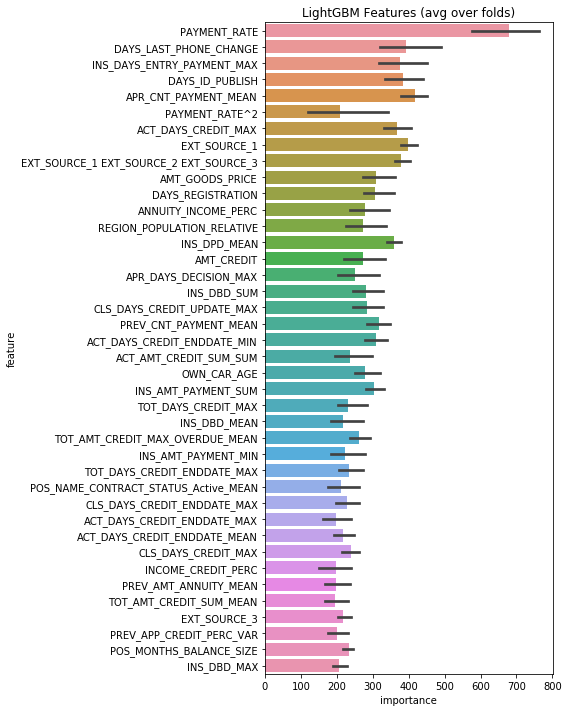

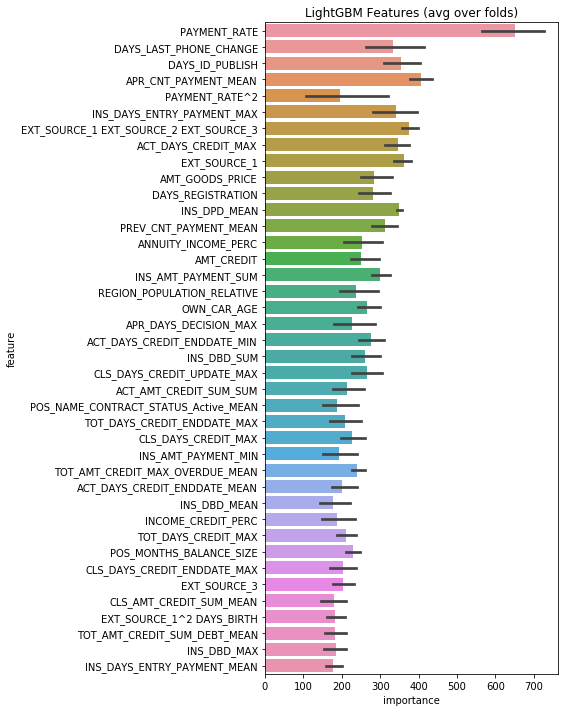

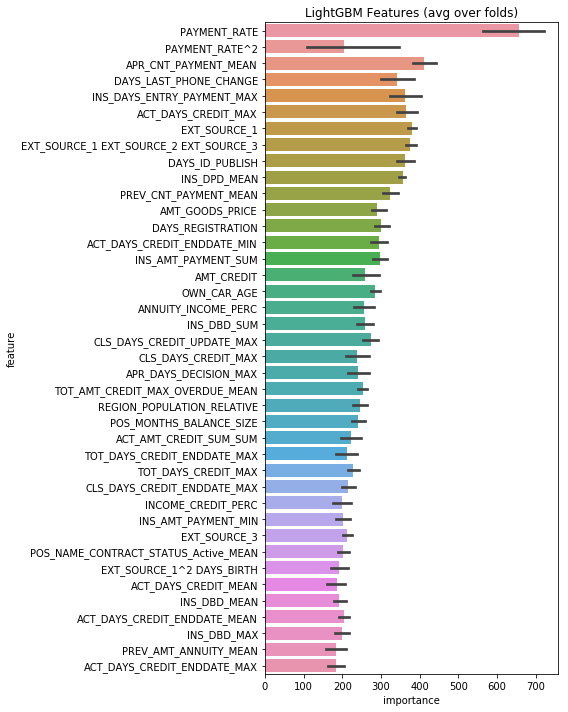

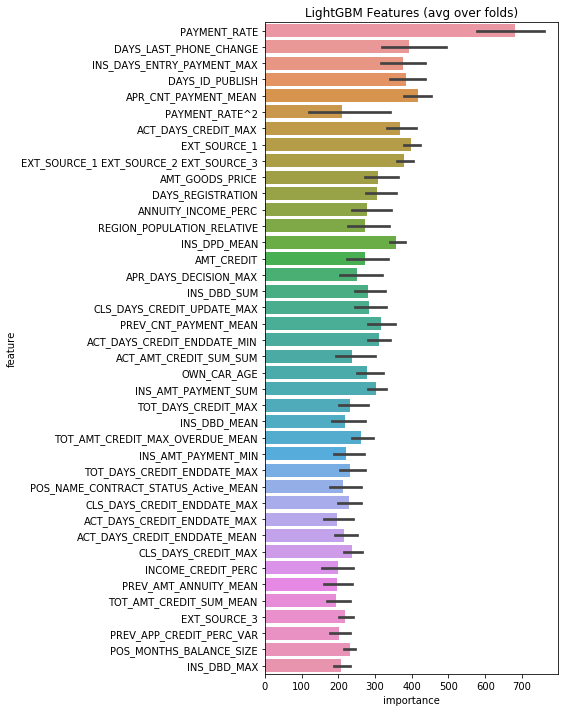

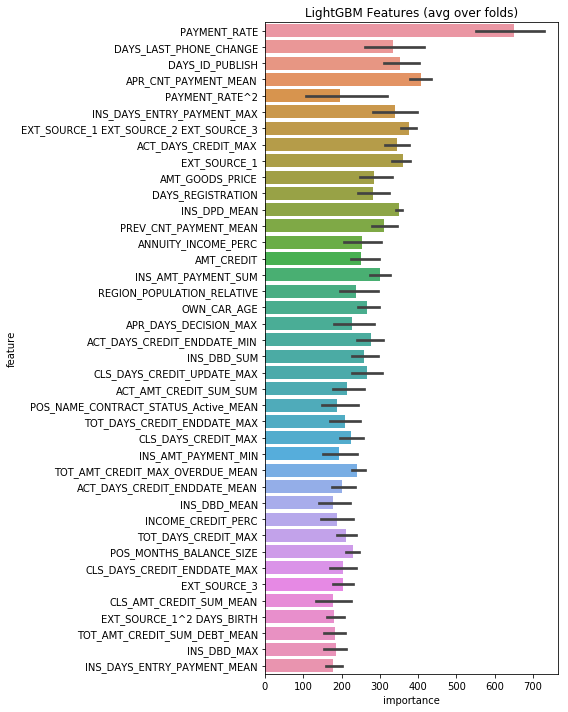

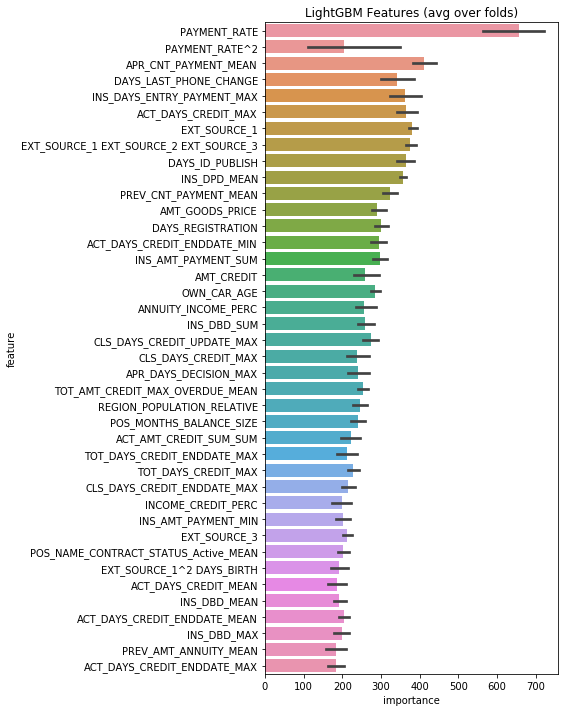

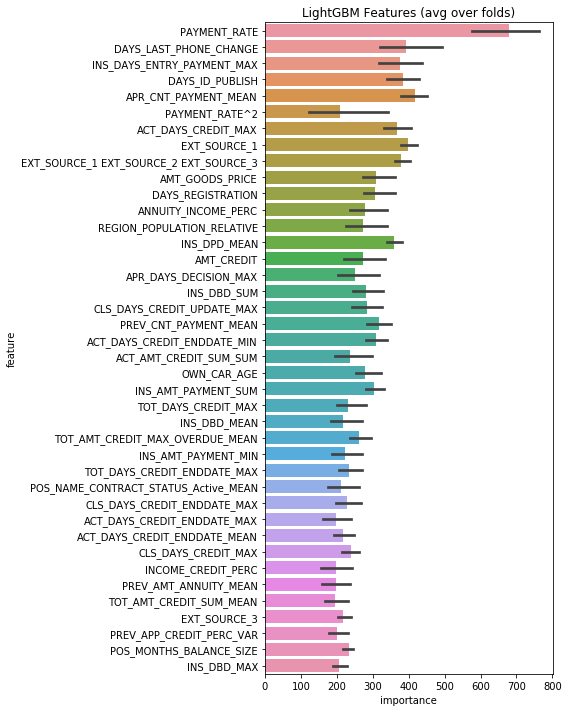

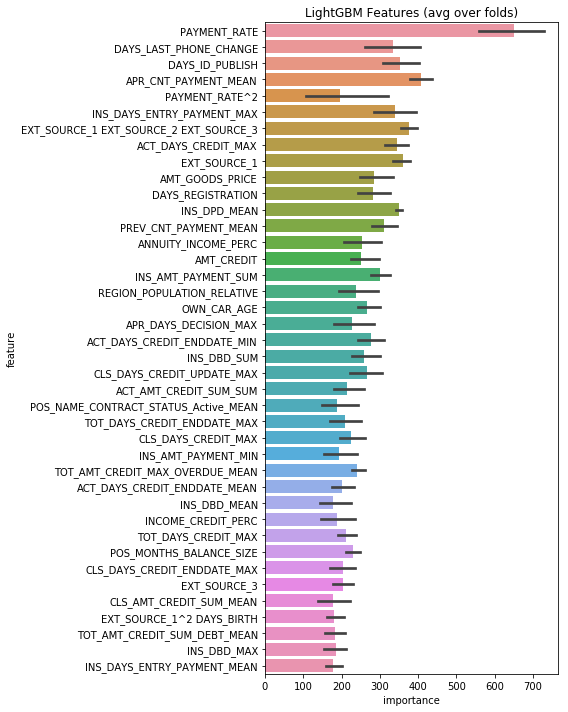

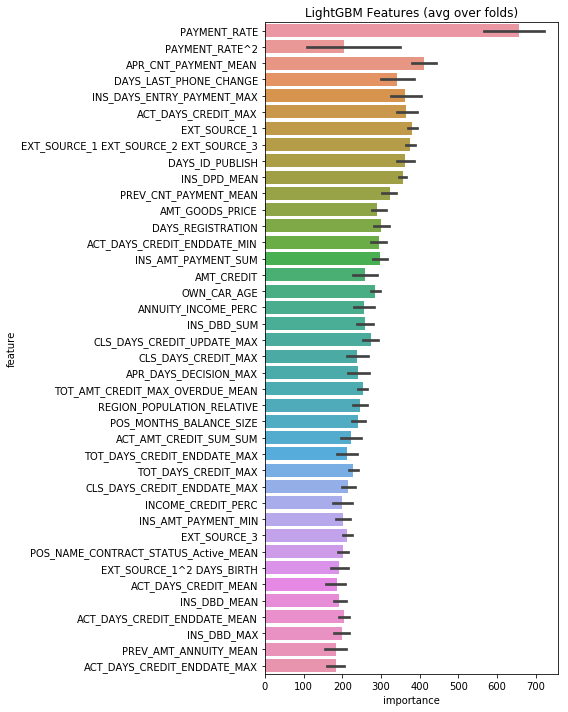

In [46]:
# GRID SEARCH BY HAND

grid_n_estimators = [9000, 10000, 11000]
grid_num_leaves = [32, 34, 36]

for n_estimators in grid_n_estimators:
    for num_leaves in grid_num_leaves:
        
        filename = 'submission_full_grid_n_estimators_'+str(n_estimators)+'_num_leaves_'+str(num_leaves)
        print(filename)
        
        feat_importance = kfold_lightgbm_grid(data_all_final, num_folds= 5, filename = filename, n_estimators=n_estimators, learning_rate=0.02, num_leaves=num_leaves, stratified = True, debug = False)
        

# FOCUS ON MOST IMPORTANT FEATURES

In [54]:
feat_importance.sort_values(by=['importance'],ascending=False)[0:7]

,feature,importance,fold
782,PAYMENT_RATE,728,4
782,PAYMENT_RATE,726,1
782,PAYMENT_RATE,701,3
782,PAYMENT_RATE,654,5
805,PAYMENT_RATE^2,487,2
782,PAYMENT_RATE,477,2
567,APR_CNT_PAYMENT_MEAN,460,5


In [62]:
# cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_cols = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:500].index
best_features = feat_importance.loc[feat_importance.feature.isin(best_cols)]

In [66]:
data_all_final.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,PAYMENT_RATE^3,PAYMENT_RATE^2 AMT_ANNUITY,PAYMENT_RATE^2 DAYS_EMPLOYED,PAYMENT_RATE AMT_ANNUITY^2,PAYMENT_RATE AMT_ANNUITY DAYS_EMPLOYED,PAYMENT_RATE DAYS_EMPLOYED^2,AMT_ANNUITY^3,AMT_ANNUITY^2 DAYS_EMPLOYED,AMT_ANNUITY DAYS_EMPLOYED^2,DAYS_EMPLOYED^3
0,100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,0.000224,91.156539,-2.350832,3.706402e+07,-9.558422e+05,24650.169232,1.507014e+13,-3.886431e+11,1.002270e+10,-2.584749e+08
1,100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,0.000021,27.190385,-0.904861,3.517083e+07,-1.170440e+06,38950.727798,4.549356e+13,-1.513967e+12,5.038286e+10,-1.676677e+09
2,100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,0.000125,16.875000,-0.562500,2.278125e+06,-7.593750e+04,2531.250000,3.075469e+11,-1.025156e+10,3.417188e+08,-1.139062e+07
3,100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0.000856,267.589977,-27.393123,8.367070e+07,-8.565350e+06,876832.870936,2.616236e+13,-2.678235e+12,2.741703e+11,-2.806675e+10
4,100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,39.723134,-5.519146,2.037797e+07,-2.831322e+06,393384.810491,1.045390e+13,-1.452468e+12,2.018064e+11,-2.803905e+10


In [67]:
data_all_final_reduced = data_all_final[["SK_ID_CURR", "TARGET"]]

In [73]:
for col in best_cols:
    data_all_final_reduced = data_all_final_reduced.join(data_all_final[col])

In [74]:
data_all_final_reduced.head()

,SK_ID_CURR,TARGET,PAYMENT_RATE,APR_CNT_PAYMENT_MEAN,EXT_SOURCE_1,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,ACT_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DPD_MEAN,...,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_RECIVABLE_MAX,AMT_REQ_CREDIT_BUREAU_MON,YEARS_BUILD_AVG,CREDIT_ACTIVE_Sold,WEEKDAY_APPR_PROCESS_START_MONDAY,CC_AMT_RECIVABLE_MIN,PREV_AMT_GOODS_PRICE_MAX,PA_CODE_REJECT_REASON_LIMIT,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR
0,100002,1.0,0.060749,24.000000,0.083037,0.003043,-103.0,-2120,-49.0,0.000000,...,NaN,NaN,0.0,0.6192,0.0,0,NaN,179055.0,0.000000,NaN
1,100003,0.0,0.027598,10.000000,0.311267,0.103327,-606.0,-291,-544.0,0.000000,...,NaN,NaN,0.0,0.7960,0.0,1,NaN,900000.0,0.000000,NaN
2,100004,0.0,0.050000,4.000000,NaN,0.205284,NaN,-2531,-727.0,0.000000,...,NaN,NaN,0.0,NaN,0.0,1,NaN,24282.0,0.000000,NaN
3,100006,0.0,0.094941,18.000000,NaN,0.175635,NaN,-2437,-12.0,0.000000,...,NaN,0.0,NaN,NaN,NaN,0,0.0,688500.0,0.111111,0.0
4,100007,0.0,0.042623,20.666667,NaN,0.087147,NaN,-3458,-14.0,0.954545,...,NaN,NaN,0.0,NaN,0.0,0,NaN,247500.0,0.000000,NaN


Starting LightGBM. Train shape: (307511, 502), test shape: (48744, 502)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.777144	valid_1's auc: 0.760757
[200]	training's auc: 0.799256	valid_1's auc: 0.775363
[300]	training's auc: 0.813185	valid_1's auc: 0.78189
[400]	training's auc: 0.824055	valid_1's auc: 0.785609
[500]	training's auc: 0.833078	valid_1's auc: 0.787992
[600]	training's auc: 0.841071	valid_1's auc: 0.789468
[700]	training's auc: 0.847798	valid_1's auc: 0.790522
[800]	training's auc: 0.854035	valid_1's auc: 0.791201
[900]	training's auc: 0.860154	valid_1's auc: 0.791824
[1000]	training's auc: 0.866038	valid_1's auc: 0.792201
[1100]	training's auc: 0.87159	valid_1's auc: 0.792507
[1200]	training's auc: 0.876687	valid_1's auc: 0.792583
[1300]	training's auc: 0.881562	valid_1's auc: 0.792639
[1400]	training's auc: 0.886245	valid_1's auc: 0.79275
[1500]	training's auc: 0.890835	valid_1's auc: 0.792707
[1600]	training's auc: 0.895317	valid

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


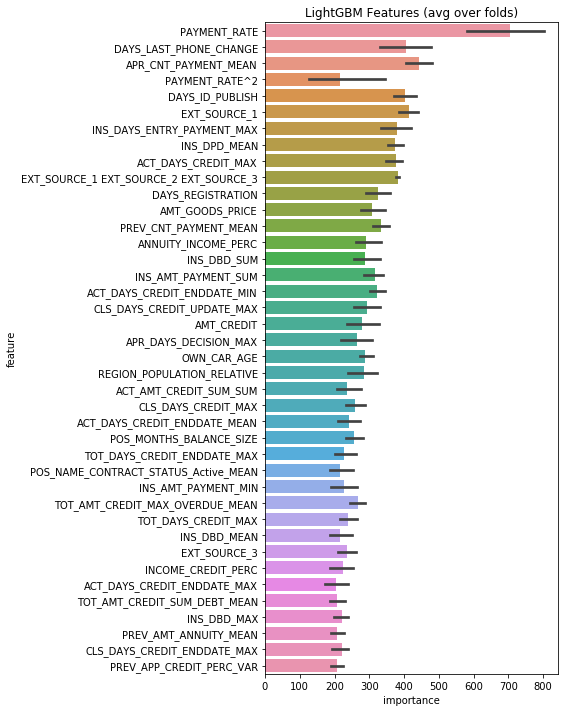

In [79]:
# set the filename
filename = 'submission_full_7_reduced_LGBM_kfold_strat_obj_binary'
# run LGBM with reduced number of features
feat_importance_red = kfold_lightgbm(data_all_final_reduced, num_folds= 5, filename = filename, stratified = True, debug = False)

# DEEP NEURAL NETWORK

In [87]:
data_all_final_reduced_norm = data_all_final_reduced.set_index('SK_ID_CURR')
data_all_final_reduced_norm = clean_numerical_data(data_all_final_reduced_norm)
# data_all_final_reduced_norm = data_all_final_reduced_norm.reset_index()
data_all_final_reduced_norm.head()

,PAYMENT_RATE,APR_CNT_PAYMENT_MEAN,EXT_SOURCE_1,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,ACT_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DPD_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CNT_PAYMENT_MEAN,...,CC_AMT_RECIVABLE_MAX,AMT_REQ_CREDIT_BUREAU_MON,YEARS_BUILD_AVG,CREDIT_ACTIVE_Sold,WEEKDAY_APPR_PROCESS_START_MONDAY,CC_AMT_RECIVABLE_MIN,PREV_AMT_GOODS_PRICE_MAX,PA_CODE_REJECT_REASON_LIMIT,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.227799,1.424195,-2.954533e+00,-1.544100,8.065805e-01,0.581113,0.532621,-0.119355,-0.025837,1.155118,...,0.000000,-2.908006e-01,-2.024891e+00,-1.095122e-01,-0.446057,-7.729394e-17,-0.485919,-0.279303,0.000000,1.0
100003,-1.200840,-0.489597,-1.344914e+00,-0.398728,-4.749647e-01,1.786068,-0.410886,-0.119355,0.381537,-0.553165,...,0.000000,-2.908006e-01,6.651623e-01,-1.095122e-01,2.241866,-7.729394e-17,1.268230,-0.279303,0.000000,0.0
100004,-0.235440,-1.309794,-7.829967e-16,0.765744,1.448259e-16,0.310344,-0.759697,-0.119355,0.398844,-1.285286,...,0.000000,-2.908006e-01,-1.689230e-15,-1.095122e-01,2.241866,-7.729394e-17,-0.862500,-0.279303,0.000000,0.0
100006,1.701305,0.603998,-7.829967e-16,0.427119,1.448259e-16,0.372272,0.603145,-0.119355,0.662439,1.033098,...,-1.539616,-3.483568e-17,-1.689230e-15,2.501479e-17,-0.446057,-4.308846e-01,0.753624,0.971160,-0.327557,0.0
100007,-0.553360,0.968530,-7.829967e-16,-0.583525,1.448259e-16,-0.300368,0.599333,-0.008428,0.011439,0.748384,...,0.000000,-2.908006e-01,-1.689230e-15,-1.095122e-01,-0.446057,-7.729394e-17,-0.319383,-0.279303,0.000000,0.0


In [143]:
# split data into train (Y labeled) and test set (Y unknown)

Y_train = data_all_final_reduced_norm['TARGET'][pd.notnull(data_all_final_reduced_norm['TARGET']).values]
X_train = data_all_final_reduced_norm[pd.notnull(data_all_final_reduced_norm['TARGET']).values]

Y_test = data_all_final_reduced_norm['TARGET'][pd.isnull(data_all_final_reduced_norm['TARGET']).values]
X_test = data_all_final_reduced_norm[pd.isnull(data_all_final_reduced_norm['TARGET']).values]
X_train = X_train.drop(['TARGET'], axis=1)
X_test = X_test.drop(['TARGET'], axis=1)
print('len (test)', X_test.shape)
print('len (train)', X_train.shape)

len (test) (48744, 500)
len (train) (307511, 500)


In [144]:
# split training data into training and dev set
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

In [156]:
# Build the model architecture
nn_model2 = Sequential()
#nn_model2.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
#nn_model2.add(Dropout(.2))
#nn_model2.add(Dense(256, activation='relu'))
nn_model2.add(Dense(256, activation='relu',input_dim=X_train.shape[1]))
nn_model2.add(Dropout(.2))
nn_model2.add(Dense(128, activation='relu'))
nn_model2.add(Dropout(.1))
nn_model2.add(Dense(64, activation='relu'))
nn_model2.add(Dropout(.1))
nn_model2.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
nn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
nn_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               128256    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total para

Epoch 1/30
246008/246008 [==============================] - 21s 84us/step - loss: 0.2548 - acc: 0.9190
Epoch 2/30
246008/246008 [==============================] - 19s 79us/step - loss: 0.2461 - acc: 0.9193
Epoch 3/30
246008/246008 [==============================] - 18s 73us/step - loss: 0.2429 - acc: 0.9193
Epoch 4/30
246008/246008 [==============================] - 18s 72us/step - loss: 0.2412 - acc: 0.9196
Epoch 5/30
246008/246008 [==============================] - 18s 72us/step - loss: 0.2393 - acc: 0.9198
Epoch 6/30
246008/246008 [==============================] - 17s 71us/step - loss: 0.2373 - acc: 0.9200
Epoch 7/30
246008/246008 [==============================] - 18s 73us/step - loss: 0.2352 - acc: 0.9203
Epoch 8/30
246008/246008 [==============================] - 18s 73us/step - loss: 0.2332 - acc: 0.9208
Epoch 9/30
246008/246008 [==============================] - 18s 73us/step - loss: 0.2304 - acc: 0.9214
Epoch 10/30
246008/246008 [==============================] - 18s 73us/ste

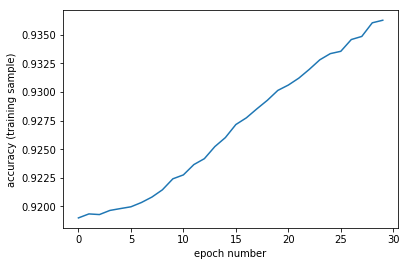

In [157]:
# Training the model
history = nn_model2.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=1)

# plot metrics
plt.plot(history.history['acc'])
plt.xlabel('epoch number')
plt.ylabel('accuracy (training sample)')
plt.show()

In [158]:
# Evaluating the model on the training and testing set
score2 = nn_model2.evaluate(X_train, Y_train)
print("\n Training Accuracy:", score2[1])
score2 = nn_model2.evaluate(X_dev, Y_dev)
print("\n Dev-set Accuracy:", score2[1])

246008/246008 [==============================] - 10s 41us/step

 Training Accuracy: 0.9458716789678513
61503/61503 [==============================] - 2s 38us/step

 Dev-set Accuracy: 0.9132725232934851


In [159]:
# plot confusion matrix
Y_pred2 = nn_model2.predict_classes(X_dev)[:,0]

print('Confusion matrix: \n', confusion_matrix(Y_dev, Y_pred2))

Confusion matrix: 
 [[55677   877]
 [ 4457   492]]


In [150]:
print('Number of true positives (Y=1) in dev set:', Y_dev.sum())
print('Number of predicted positives (Y=1) in dev set:', Y_pred2.sum())

Number of true positives (Y=1) in dev set: 4949.0
Number of predicted positives (Y=1) in dev set: 2456


AUC score Deep NN model: 0.7010053666684404


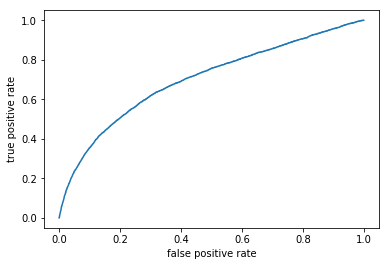

In [160]:
# plot ROC curve
pred_nn_proba2 = nn_model2.predict_proba(X_dev)[:, 0]

fpr, tpr, thresholds = roc_curve(Y_dev, pred_nn_proba2)
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

nn_model_auc2 = roc_auc_score(Y_dev, pred_nn_proba2)
print('AUC score Deep NN model:', nn_model_auc2)

## Custom loss function

In [1]:
# weighted loss function
def get_weighted_loss():
    def weighted_loss(y_true, y_pred):
        # introduce weight parameter for penalizing stronger wrong predictions on y=1 
        weight_loss_y1 = 0.55
        # introduce small epsilon parameter to avoid nan b/c of divergence
        epsilon = 10**(-6)
        
        return - (weight_loss_y1 * y_true * K.log(y_pred+epsilon) +
                  (1-weight_loss_y1) * (1-y_true) * K.log(1-y_pred+epsilon))
    return weighted_loss

In [ ]:
# Build the model architecture
nn_model3 = Sequential()
nn_model3.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
nn_model3.add(Dropout(.2))
nn_model3.add(Dense(128, activation='relu'))
nn_model3.add(Dropout(.1))
nn_model3.add(Dense(64, activation='relu'))
nn_model3.add(Dropout(.1))
nn_model3.add(Dense(1, activation='sigmoid'))

# Compile the model using a loss function and an optimizer.
nn_model3.compile(loss=get_weighted_loss(), optimizer='adam', metrics=['acc'])
nn_model3.summary()

In [ ]:
# Training the model
history = nn_model3.fit(X_train, Y_train, epochs=20, batch_size=100, verbose=1)

# plot metrics
plt.plot(history.history['acc'])
plt.xlabel('epoch number')
plt.ylabel('accuracy (training sample)')
plt.show()

In [ ]:
# Evaluating the model on the training and testing set
score3 = nn_model3.evaluate(X_train, Y_train)
print("\n Training Accuracy:", score3[1])
score3 = nn_model3.evaluate(X_dev, Y_dev)
print("\n Dev-set Accuracy:", score3[1])

In [ ]:
# plot confusion matrix
Y_pred3 = nn_model3.predict_classes(X_dev)[:,0]

confusion_matrix(Y_dev, Y_pred3)

In [ ]:
print(Y_dev.sum())
print(Y_pred3.sum())

In [ ]:
# plot ROC curve
pred_nn_proba3 = nn_model3.predict_proba(X_dev)[:, 0]

fpr, tpr, thresholds = roc_curve(Y_dev, pred_nn_proba3)
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

nn_model_auc3 = roc_auc_score(Y_dev, pred_nn_proba3)
print(nn_model_auc3)

In [ ]:
# define submission filename
model_name = 'deepNN_weighted'
submission_name = ('submission_full_1_model_' + model_name + '.csv')

# predicted probabilities on test set
Y_pred_prob = nn_model3.predict_proba(X_test)[:, 0]

# my_submission = pd.DataFrame({'SK_ID_CURR': X_test.index, 'TARGET': Y_pred})
my_submission = pd.DataFrame({'SK_ID_CURR': X_test.index, 'TARGET': Y_pred_prob})
# you could use any filename.
my_submission.to_csv(submission_name, index=False)